<a href="https://colab.research.google.com/github/Poorneshsharma12/Machine-Learning-Visualization-model/blob/main/Melbourne_Housing_ML_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

**Load and Inspect the Data**

In [34]:
# Load the dataset
df = pd.read_csv('melb_data.csv')  # Update path as needed
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())


Initial shape: (13580, 21)
Columns: ['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']


**Preprocessing Steps**

In [35]:
# Drop irrelevant columns
df = df.drop(['Address', 'SellerG', 'Method', 'Date', 'CouncilArea', 'Postcode', 'Propertycount'], axis=1)

# Drop rows with missing target values
df = df[df['Price'].notnull()]

# Impute numeric missing values and flag missingness
imputer = KNNImputer(n_neighbors=5)  # Better imputation for numeric data
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = imputer.fit_transform(df[num_cols])
df['BuildingArea_missing'] = df['BuildingArea'].isna().astype(int)  # Flag missing BuildingArea

# Encode categorical features
cat_cols = ['Suburb', 'Regionname', 'Type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Fixed parameter
encoded = pd.DataFrame(encoder.fit_transform(df[cat_cols]))
encoded.columns = encoder.get_feature_names_out(cat_cols)
df = pd.concat([df.drop(cat_cols, axis=1), encoded], axis=1)

# Cap outliers in Price
price_cap = df['Price'].mean() + 3 * df['Price'].std()
df['Price'] = df['Price'].clip(upper=price_cap)

**Now Feature Selection**

In [38]:
# Check correlations and drop highly correlated features if present
features_to_check = ['Rooms', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Distance']
if 'Bedroom2' in df.columns:
    features_to_check.append('Bedroom2')
    corr_matrix = df[features_to_check].corr()
    if corr_matrix['Rooms']['Bedroom2'] > 0.9:
        df = df.drop('Bedroom2', axis=1)
features = ['Rooms', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Distance', 'Lattitude', 'Longtitude'] + encoded.columns.tolist()
X = df[features]
y = df['Price']

**Train/Test Split**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Model Training & Evaluation**

**1-Gradient Boosting Regressor (GBR)**

In [40]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5]}
grid_gbr = GridSearchCV(gbr, param_grid, cv=5, scoring='r2')
grid_gbr.fit(X_train_scaled, y_train)
gbr_best = grid_gbr.best_estimator_
gbr_preds = gbr_best.predict(X_test_scaled)

# Evaluate GBR
gbr_r2 = r2_score(y_test, gbr_preds)
gbr_mae = mean_absolute_error(y_test, gbr_preds)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_preds))
cv_scores_gbr = cross_val_score(gbr_best, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"GBR Best Params: {grid_gbr.best_params_}")
print(f"GBR CV R²: {cv_scores_gbr.mean():.3f} (+/- {cv_scores_gbr.std() * 2:.3f})")

GBR Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
GBR CV R²: 0.857 (+/- 0.016)


**2-K-Nearest Neighbors Regressor (KNN)**

In [41]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
grid_knn.fit(X_train_scaled, y_train)
knn_best = grid_knn.best_estimator_
knn_preds = knn_best.predict(X_test_scaled)

# Evaluate KNN
knn_r2 = r2_score(y_test, knn_preds)
knn_mae = mean_absolute_error(y_test, knn_preds)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
cv_scores_knn = cross_val_score(knn_best, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"KNN Best Params: {grid_knn.best_params_}")
print(f"KNN CV R²: {cv_scores_knn.mean():.3f} (+/- {cv_scores_knn.std() * 2:.3f})")

KNN Best Params: {'n_neighbors': 7, 'weights': 'distance'}
KNN CV R²: 0.745 (+/- 0.025)


**Compare Model Performance**

In [43]:
print("\nModel Comparison:")
print(f"{'Model':<30}{'R² Score':<12}{'MAE':<20}{'RMSE':<20}")
print(f"{'Gradient Boosting':<30}{gbr_r2:<12.3f}${gbr_mae:<20,.2f}${gbr_rmse:<20,.2f}")
print(f"{'K-Nearest Neighbors':<30}{knn_r2:<12.3f}${knn_mae:<20,.2f}${knn_rmse:<20,.2f}")




Model Comparison:
Model                         R² Score    MAE                 RMSE                
Gradient Boosting             0.865       $145,684.01          $216,628.01          
K-Nearest Neighbors           0.744       $198,824.09          $297,913.78          


**Plot Predicted vs Actual**

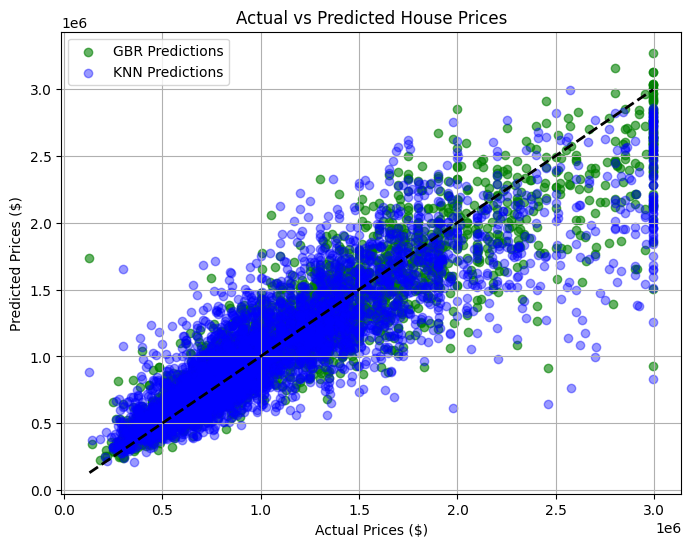

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gbr_preds, alpha=0.6, color='green', label='GBR Predictions')
plt.scatter(y_test, knn_preds, alpha=0.4, color='blue', label='KNN Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.show()

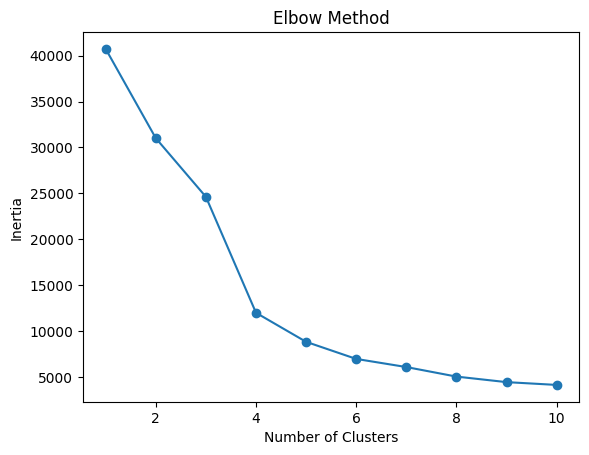


Cluster Counts:
 Cluster
0    7097
1    3575
2    2907
3       1
Name: count, dtype: int64


In [47]:
cluster_features = df[['Price', 'Distance', 'BuildingArea']]
scaler_cluster = StandardScaler()
scaled_cluster = scaler_cluster.fit_transform(cluster_features)

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_cluster)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_cluster)

# Cluster distribution
print("\nCluster Counts:\n", df['Cluster'].value_counts())

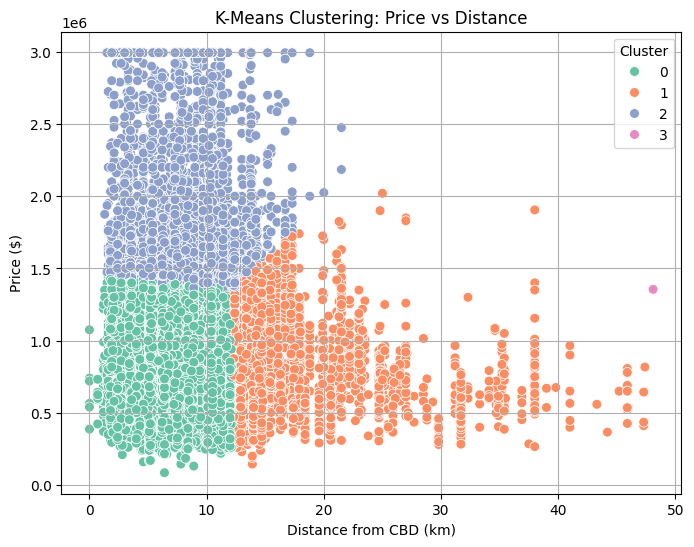

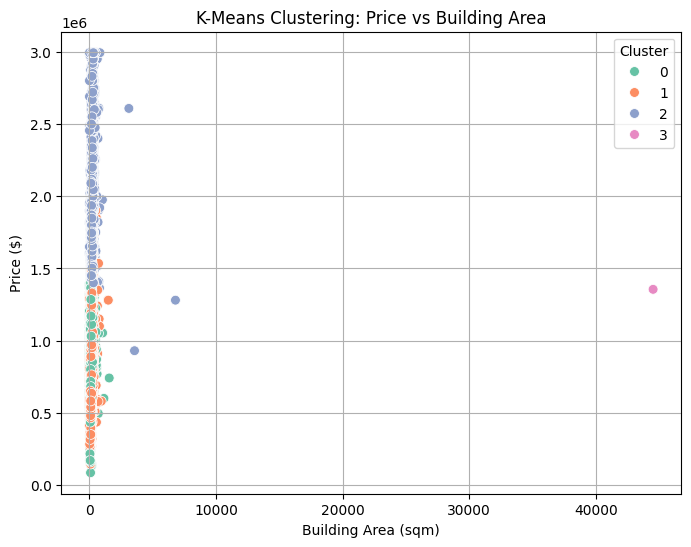

In [48]:
# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Distance', y='Price', hue='Cluster', palette='Set2', s=50)
plt.title('K-Means Clustering: Price vs Distance')
plt.xlabel('Distance from CBD (km)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='BuildingArea', y='Price', hue='Cluster', palette='Set2', s=50)
plt.title('K-Means Clustering: Price vs Building Area')
plt.xlabel('Building Area (sqm)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

**Code for Processed Tableau Data**

In [58]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the dataset
df = pd.read_csv('melb_data.csv')  # Adjust path if needed
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# Step 2: Data preprocessing
# Drop irrelevant columns but keep Suburb and YearBuilt for later use
df_temp = df.drop(['Address', 'SellerG', 'Method', 'Date', 'CouncilArea', 'Postcode', 'Propertycount'], axis=1)

# Drop rows with missing target values
df_temp = df_temp[df_temp['Price'].notnull()]

# Preserve original Suburb and YearBuilt columns
suburb_col = df_temp['Suburb'].copy()
yearbuilt_col = df_temp['YearBuilt'].copy()

# Impute numeric missing values comprehensively
imputer = KNNImputer(n_neighbors=5)
numeric_cols = ['Rooms', 'Distance', 'Lattitude', 'Longtitude', 'Price', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
for col in numeric_cols:
    if df_temp[col].isna().any():
        print(f"Imputing NaN values in {col}")
df_temp[numeric_cols] = imputer.fit_transform(df_temp[numeric_cols])

# Verify no NaNs remain in numeric columns
print("NaN check after imputation:", df_temp[numeric_cols].isna().sum())

# Encode categorical features (excluding Suburb from encoding)
cat_cols = ['Regionname', 'Type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
encoded = pd.DataFrame(encoder.fit_transform(df_temp[cat_cols]))
encoded.columns = encoder.get_feature_names_out(cat_cols)
print("NaN check after encoding:", encoded.isna().sum())

# Combine encoded and numeric data
df_temp = pd.concat([df_temp.drop(cat_cols, axis=1), encoded], axis=1)

# Reintroduce Suburb and YearBuilt (not encoded) for Tableau
df_temp['Suburb'] = suburb_col
df_temp['YearBuilt'] = yearbuilt_col

# Cap outliers in Price
price_cap = df_temp['Price'].mean() + 3 * df_temp['Price'].std()
df_temp['Price'] = df_temp['Price'].clip(upper=price_cap)

# Step 3: Feature selection and pipeline
numeric_features = ['Rooms', 'Distance', 'Lattitude', 'Longtitude', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
encoded_features = encoded.columns.tolist()
model_features = numeric_features + encoded_features
X = df_temp[model_features]
y = df_temp['Price']

# Final NaN check and imputation before modeling
if X.isna().any().any():
    print("Residual NaNs detected, applying final imputation")
    imputer_final = KNNImputer(n_neighbors=5)
    X = pd.DataFrame(imputer_final.fit_transform(X), columns=X.columns)

# Step 4: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify no NaNs in scaled data
print("NaN check in X_train_scaled:", np.isnan(X_train_scaled).sum())

# Step 5: Train GBR and KNN models
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gbr.fit(X_train_scaled, y_train)
gbr_preds = gbr.predict(X_test_scaled)

knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)

# Step 6: Apply K-Means clustering
cluster_features = df_temp[['Price', 'Distance', 'BuildingArea']]
scaler_cluster = StandardScaler()
scaled_cluster = scaler_cluster.fit_transform(cluster_features)
kmeans = KMeans(n_clusters=4, random_state=42)
df_temp['Cluster'] = kmeans.fit_predict(scaled_cluster)

# Step 7: Combine predictions and clusters with original data
X_scaled = scaler.transform(X)
df_temp['GBR_Predicted_Price'] = gbr.predict(X_scaled)
df_temp['KNN_Predicted_Price'] = knn.predict(X_scaled)

# Step 8: Select relevant columns for Tableau (including YearBuilt)
tableau_df = df_temp[['Price', 'Distance', 'BuildingArea', 'Rooms', 'Lattitude', 'Longtitude', 'Suburb', 'YearBuilt', 'Cluster', 'GBR_Predicted_Price', 'KNN_Predicted_Price']]

# Step 9: Save to CSV for Tableau
tableau_df.to_csv('melbourne_housing_processed.csv', index=False)
print("Processed data saved to 'melbourne_housing_processed.csv'")
print("Final shape:", tableau_df.shape)
print("Columns:", tableau_df.columns.tolist())

Initial shape: (13580, 21)
Columns: ['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']
Imputing NaN values in Car
Imputing NaN values in BuildingArea
Imputing NaN values in YearBuilt
NaN check after imputation: Rooms           0
Distance        0
Lattitude       0
Longtitude      0
Price           0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
dtype: int64
NaN check after encoding: Regionname_Eastern Metropolitan          0
Regionname_Eastern Victoria              0
Regionname_Northern Metropolitan         0
Regionname_Northern Victoria             0
Regionname_South-Eastern Metropolitan    0
Regionname_Southern Metropolitan         0
Regionname_Western Metropolitan          0
Regionname_Western Victoria              0
Type_h       